## The Triple Pendulum

In this notebook I will: 
- Solve the equations of motion without assuming the small angle approximation
- Show for initial conditions outside the small angle approximation lead to chaos
- Animate the system

## Equations of Motion

From the Lagrangian (or Newtonian formulation which I used here) we can arrive at the equations of motion below. $m_i$ is the mass of the $i$th bob and $l_i$ is the length of the $i$th pendulum.

We define $\beta = \phi_3 - \phi_2$, $\alpha = \phi_3 - \phi_1$ and $\gamma = \phi_2 - \phi_1$ for convience in writing the equations of motion

$\ddot{\phi_3} = -\frac{l_3 (-\ddot{\phi_2}) + \ g \sin{(\phi_3)} + l_2 {(\dot{\phi_2}-\dot{\phi_1})}^2 \sin{\beta} + l_2(\ddot{\phi_2}-\ddot{\phi_1})\cos{\beta}+ l_1 \ddot{\phi_1} \cos{\alpha} + l_1 {\dot{\phi}_1}^2 \sin{\alpha}}{l_3}$

To more easily find the equation of motion for the second bob we find the tension in rod. The tension should not appear in the equation of motion because it is a constraint force. However, it makes the logic and the algebra I need to do by hand a lot simpler.

$T_3 = l_3 {(\dot{\phi_3}-\dot{\phi_2})}^2  - l_2(\ddot{\phi}_2-\ddot{\phi}_1)\sin{\beta} + l_2 {(\dot{\phi_2}-\dot{\phi_1})}^2 \cos{\beta} - l_1 \ddot{\phi}_1 \sin{\alpha} + l_1 {\dot{\phi}_1}^2 \cos{\beta}$

$\ddot{\phi_2}(t) = \frac{\frac{T_3}{m_2} \sin{\beta} - g \ \sin{\phi_2} - l_1 \ddot{\phi}_1 \cos{\gamma} - l_1 \ {\dot{\phi}_1}^2 \sin{\gamma} + l_2\ddot{\phi}_1}{l_2}$

Similarly to $T_3$, we define $T_2$ for ease in doing algebra.

$T_2 = T_3 \cos{\beta}+l_2 {(\dot{\phi_2}-\dot{\phi_1})}^2 - l_1 \ddot{\phi}_1 \sin{\gamma} + l_1 {\dot{\phi}_1}^2 \cos{\gamma}$

Finally we get to the equation of motion for $\phi_1$, 

$\ddot{\phi}_1  = \frac{-g \sin{\phi_1} + \frac{T_2}{m_1} \sin{\gamma}}{l_1}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import ode, odeint, solve_ivp

import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

## Initialize the Pendulum Class

In [4]:
class Pendulum():
    """
    Pendulum class implements the parameters and differential equation for 
     a pendulum using the notation from Taylor.
     
    Parameters
    ----------
    

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, m_1=1., m_2=1, m_3 = 1, l_1=1, l_2=1, l_3 = 1, g=1,
                ):
        self.m_1 = m_1
        self.m_2 = m_2
        self.m_3 = m_3
        self.l_1 = l_1
        self.l_2 = l_2
        self.l_3 = l_3
        self.g = g
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi_1/dt d^2phi_1/dt^2 dphi_2/dt d^2phi_2/dt^2 dphi_3/dt d^2phi_3/dt^2]
        
        Parameters
        ----------
        y : float
            A 6-component vector with y[0] = phi_1(t), y[1] = dphi_1/dt, y[2] = phi_2(t), y[3] = dphi_2/dt, y[4] = phi_3(t), y[5] = dphi_3/dt
        t : float
            time 
            
        Returns
        -------
        
        """
        dy = np.zeros(6)
        
        # Find alpha, gamma, beta
        beta = y[4] - y[2]
        alpha = y[4] - y[0]
        gamma = y[2] - y[0]
        
        # Find the tension forces
        T_3 = self.l_3*(-y[3]+y[5])**2  - self.l_2*(-dy[1]+dy[3])*np.sin(beta) + self.l_2*(-y[1]+y[3])**2 * np.cos(beta) - self.l_1*dy[1]*np.sin(alpha) + self.l_1*y[1]**2 * np.cos(beta)
        T_2 = T_3*np.cos(beta)+self.l_2*(-y[1]+y[3])**2 - self.l_1*dy[1]*np.sin(gamma) + self.l_1*y[1]**2 * np.cos(gamma)
        
        dy[0] = y[1]
        dy[1] = (-self.g*np.sin(y[0]) + T_2/self.m_1 * np.sin(gamma))/self.l_1
        dy[2] = y[3]
        dy[3] = (T_3/self.m_2 * np.sin(beta) - self.g*np.sin(y[2])- self.l_1*dy[1]*np.cos(gamma) - self.l_1*y[1]**2 *np.sin(gamma) + self.l_2*dy[1])/self.l_2
        dy[4] = y[5]
        dy[5] = -(-self.l_3* dy[2] + self.g* np.sin(y[4]) + self.l_2*(y[3]-y[1])**2 *np.sin(beta) + self.l_2*(-dy[1]+dy[3])*np.cos(beta)+ self.l_1 *dy[1] *np.cos(alpha) + self.l_1* y[1]**2 * np.sin(alpha))/self.l_3
        return dy
    
    def solve_ode(self, t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0, phi_3_0, phi_3_dot_0,
                  method='RK23',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0, phi_3_0, phi_3_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_1_dot, phi_2, phi_2_dot, phi_3, phi_3_dot    = solution.y
        return phi_1, phi_1_dot, phi_2, phi_2_dot, phi_3, phi_3_dot  
    

In [5]:
# Problem parameters
m_1 = 1.
m_2 = 1.
m_3 = 1.
l_1 = 1.
l_2 = 1.
l_3 = 1.
g = 1.

# Time vector
t_start = 0.
t_end = 10.
delta_t = 0.01
t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Get Double Pendulum
p1 = Pendulum(m_1, m_2, m_3, l_1, l_2, l_3, g)

# Initial conditions
phi_1_0 = -1.
phi_1_dot_0 = 0.
phi_2_0 =  -1.25
phi_2_dot_0 = 0.
phi_3_0 =  -1.5
phi_3_dot_0 = 0.

phi_1, phi_1_dot, phi_2, phi_2_dot,phi_3, phi_3_dot = p1.solve_ode(t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0, phi_3_0, phi_3_dot_0)


## Make figures to show chaos

Plan: Plot generalized coordinates vs time and state space figures to show chaos.


ValueError: x and y must have same first dimension, but have shapes (1001,) and (500,)

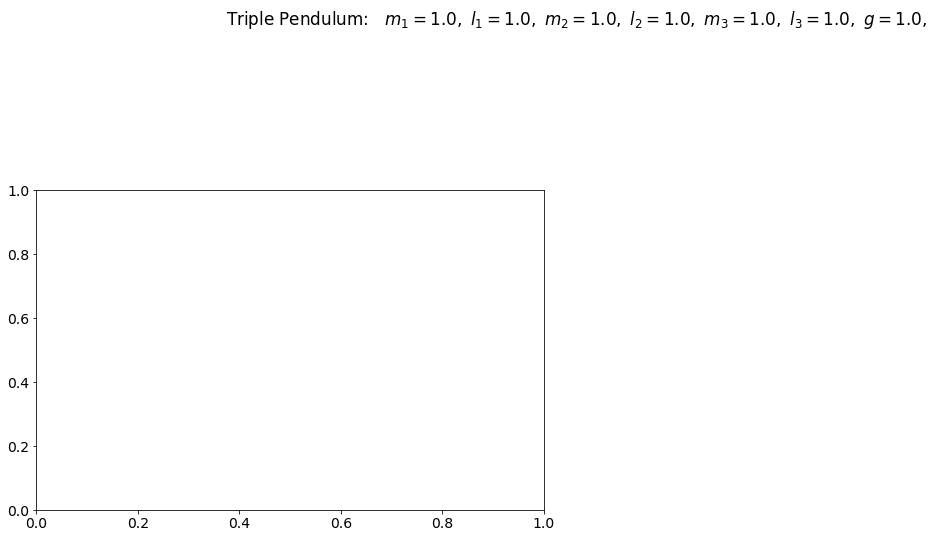

In [6]:
fig = plt.figure(figsize=(20,20))

overall_title = 'Triple Pendulum:  ' + \
                rf' $m_1 = {p1.m_1},$' + \
                rf' $l_1 = {p1.l_1},$' + \
                rf' $m_2 = {p1.m_2},$' + \
                rf' $l_2 = {p1.l_2},$' + \
                rf' $m_3 = {p1.m_3},$' + \
                rf' $l_3 = {p1.l_3},$' + \
                rf' $g = {p1.g},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

ax_4a = fig.add_subplot(3,2,1)
ax_4a.plot(t_pts, phi_1, color='blue')
ax_4a.set_xlabel('time')
ax_4a.set_ylabel('$\phi_1(t)$')
ax_4a.set_title('$\phi_1(t)$ vs time')

ax_4b = fig.add_subplot(3,2,2)
ax_4b.plot(phi_1, phi_1_dot, color='blue')
ax_4b.set_xlabel('$\phi_1$')
ax_4b.set_ylabel('$d \phi_1/dt$')
ax_4b.set_title(rf'$\phi_1$ State Space. $\phi_1 = {phi_1_0:.3f}$, $(d \phi_1/dt)_0 = {phi_1_dot_0:.3f}$.')

ax_4a = fig.add_subplot(3,2,3)
ax_4a.plot(t_pts, phi_2, color='blue')
ax_4a.set_xlabel('time')
ax_4a.set_ylabel('$\phi_2(t)$')
ax_4a.set_title('$\phi_2(t)$ vs time')

ax_4b = fig.add_subplot(3,2,4)
ax_4b.plot(phi_2, phi_2_dot, color='blue')
ax_4b.set_xlabel('$\phi_2$')
ax_4b.set_ylabel('$d \phi_2/dt$')
ax_4b.set_title(rf'$\phi_2$ State Space. $\phi_2 = {phi_2_0:.3f}$, $(d \phi_2/dt)_0 = {phi_2_dot_0:.3f}$.')

ax_4a = fig.add_subplot(3,2,5)
ax_4a.plot(t_pts, phi_3, color='blue')
ax_4a.set_xlabel('time')
ax_4a.set_ylabel('$\phi_3(t)$')
ax_4a.set_title('$\phi_3(t)$ vs time')

ax_4b = fig.add_subplot(3,2,6)
ax_4b.plot(phi_3, phi_3_dot, color='blue')
ax_4b.set_xlabel('$\phi_3$')
ax_4b.set_ylabel('$d \phi_3/dt$')
ax_4b.set_title(rf'$\phi_3$ State Space. $\phi_3 = {phi_3_0:.3f}$, $(d \phi_3/dt)_0 = {phi_3_dot_0:.3f}$.')


fig.tight_layout()

Looks pretty messy.

## Lets Animate!

In [51]:
%%capture

# Get x and y values from phi_1 and phi_2
x1 = l_1*np.sin(phi_1)
y1 = -l_1*np.cos(phi_1)
x2 = x1 + l_2*np.sin(phi_2)
y2 = y1 + -l_2*np.cos(phi_2)
x3 = x2 + l_3*np.sin(phi_3)
y3 = y2 + -l_3*np.cos(phi_3)

x_min = min([min(x1),min(x2),min(x3)]) 
y_min = min([min(y1),min(y2),max(x3)]) 
x_max = max([max(x1),max(x2),min(x3)]) 
y_max = max([max(y1),max(y2),max(x3)]) 

gap = 5
fig_anim = plt.figure(figsize=(10,10), num='Orbit: large mass, small mass')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min-gap, x_max+gap)
ax_anim.set_ylim(y_min-gap, y_max+gap)

# By assigning the first return from plot to line_anim, we can later change
#  the values in the line.
line_anim1, = ax_anim.plot([0, x1[0]], [0,y1[0]], color='blue', lw=2)
line_anim2, = ax_anim.plot([x1[0], x2[0]], [y1[0],y2[0]], color='red', lw=2)
line_anim2, = ax_anim.plot([x2[0], x3[0]], [y2[0],y3[0]], color='green', lw=2)

fig_anim.tight_layout()

In [52]:
def animate_wave(i):
    """This is the function called by FuncAnimation to create each frame,
        numbered by i.  So each i corresponds to a point in the t_pts
        array, with index i. 
        """

    line_anim1.set_data([0,x1[i]], [0,y1[i]])  # overwrite line_anim with new points
    line_anim2.set_data([x1[i],x2[i]], [y1[i],y2[i]])  # overwrite line_anim with new points    
    line_anim2.set_data([x2[i],x3[i]], [y2[i],y3[i]])  # overwrite line_anim with new points
    return (line_anim1, line_anim2)   # this is needed for blit=True to work

In [53]:
frame_interval = 1.  # time between frames
frame_number = 100 # number of frames to include (index of t_pts)
anim = animation.FuncAnimation(fig_anim, 
                               animate_wave, 
                               init_func=None,
                               frames=frame_number, 
                               interval=frame_interval, 
                               blit=True,
                               repeat=False)

#fig.show()

In [54]:
HTML(anim.to_jshtml())